In [202]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

In [118]:
data = pd.read_csv('train.csv')

In [119]:
data.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,...,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
0,Lvl,2003.0,2,856,706,8,Gd,61,GasA,Norm,...,2,Gd,1,1710,854,Y,Gd,856,0,208500
1,Lvl,1976.0,2,1262,978,6,TA,0,GasA,Norm,...,2,TA,1,1262,0,Y,Gd,1262,1,181500
2,Lvl,2001.0,2,920,486,6,Gd,42,GasA,Norm,...,2,Gd,1,1786,866,Y,Gd,920,1,223500
3,Lvl,1998.0,1,961,216,7,TA,35,GasA,Norm,...,3,Gd,1,1717,756,Y,TA,756,1,140000
4,Lvl,2000.0,2,1145,655,9,Gd,84,GasA,Norm,...,3,Gd,1,2198,1053,Y,Gd,1145,1,250000


In [120]:
test_data = pd.read_csv('test.csv')

In [121]:
test_data.head()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
0,Lvl,1961.0,1,896,468.0,5,TA,0,GasA,Norm,5,1.0,TA,1,896,0,Y,TA,882.0,0
1,Lvl,1958.0,1,1329,923.0,6,TA,36,GasA,Norm,6,1.0,Gd,1,1329,0,Y,TA,1329.0,0
2,Lvl,1997.0,2,928,791.0,6,TA,34,GasA,Norm,5,2.0,TA,1,1629,701,Y,Gd,928.0,1
3,Lvl,1998.0,2,926,602.0,7,TA,36,GasA,Norm,6,2.0,Gd,1,1604,678,Y,TA,926.0,1
4,HLS,1992.0,2,1280,263.0,5,Gd,82,GasA,Norm,8,2.0,Gd,1,1280,0,Y,Gd,1280.0,0


In [122]:
test_data.shape

(1459, 20)

In [123]:
pd.read_csv('sample_submission.csv').head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [124]:
y = data['SalePrice']
x = data.drop('SalePrice', axis=1)

посмотрим на числовые характеристики таргета:

In [125]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

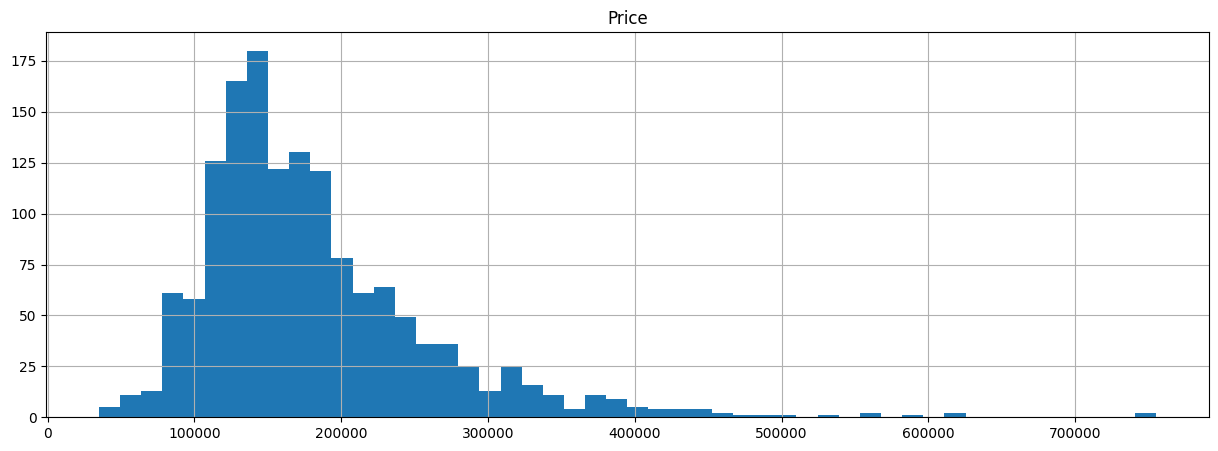

In [126]:
# plt.figure(figsize=(15, 5), dpi=300)

plt.rcParams["figure.figsize"] = (15, 5)
plt.title("Price")
data["SalePrice"].hist(bins=50);

<Axes: >

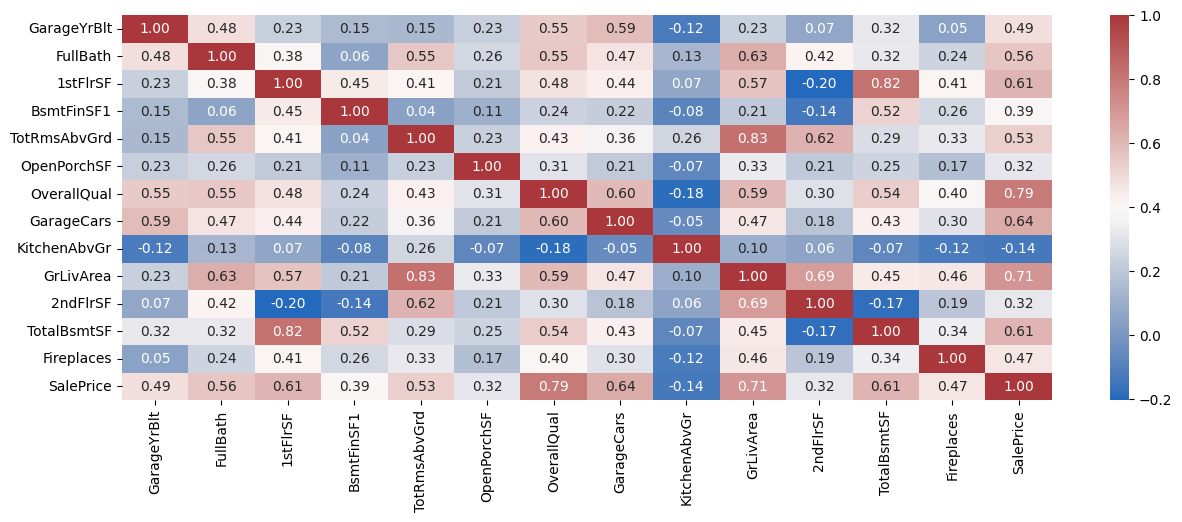

In [127]:
sns.heatmap(data[data.columns[~(data.dtypes == 'object').values]].corr(), cmap="vlag", annot=True, fmt="0.2f")

Видим наибольшую зависимость с OverallQual, GrLivArea, GarageCars, 1stFlrSF, TotalBsmtSF.

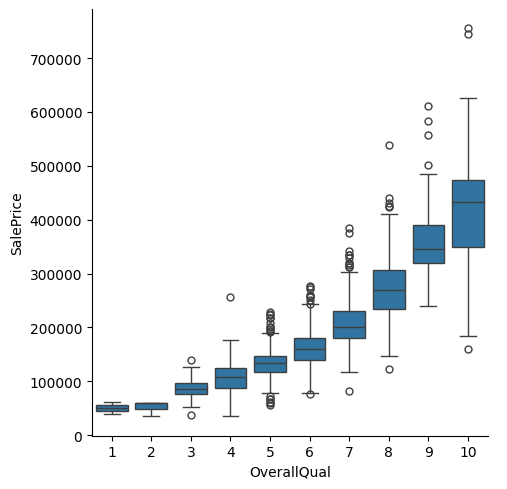

In [128]:
sns.catplot(x = "OverallQual", y = "SalePrice", data=data, kind = 'box')
plt.show()

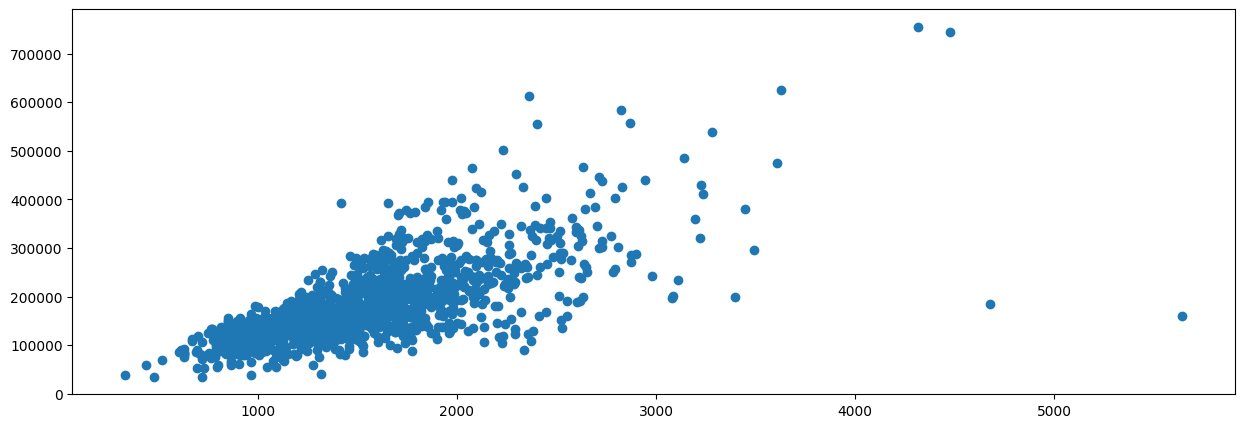

In [129]:
plt.scatter(data["GrLivArea"], data["SalePrice"])


Избавимся от выбросов справа

In [130]:
data = data.drop(data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 300000)].index)

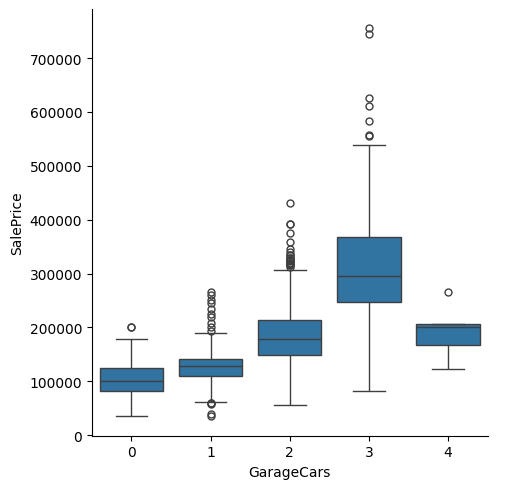

In [131]:
sns.catplot(x = "GarageCars", y = "SalePrice", data=data, kind = 'box')
plt.show()

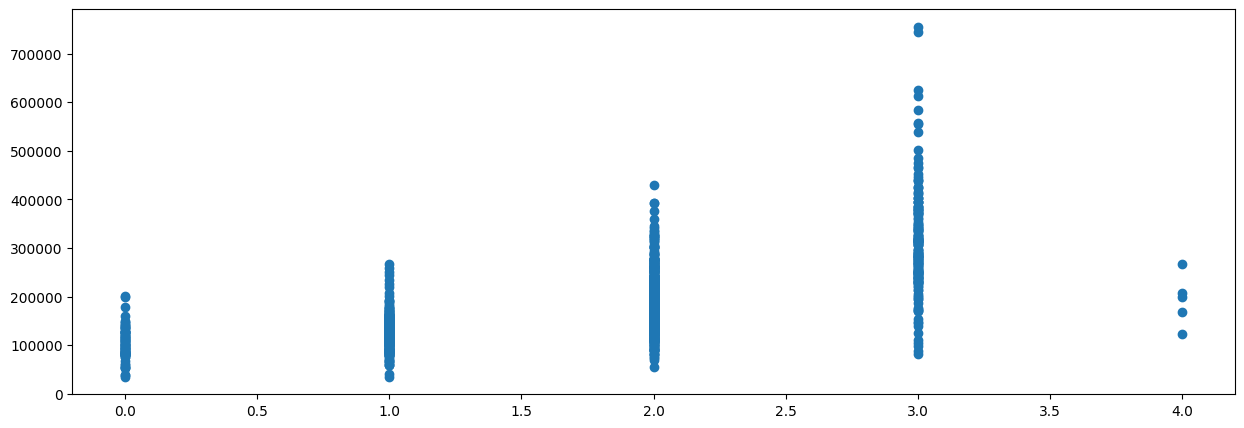

In [132]:
plt.scatter(data["GarageCars"], data["SalePrice"])


видим, что 4-хместные гаражи нарушают распределение, влияют на меньшую стоимость стоимость. Уберем их.

In [133]:
data = data.drop(data[data['GarageCars'] == 4].index)

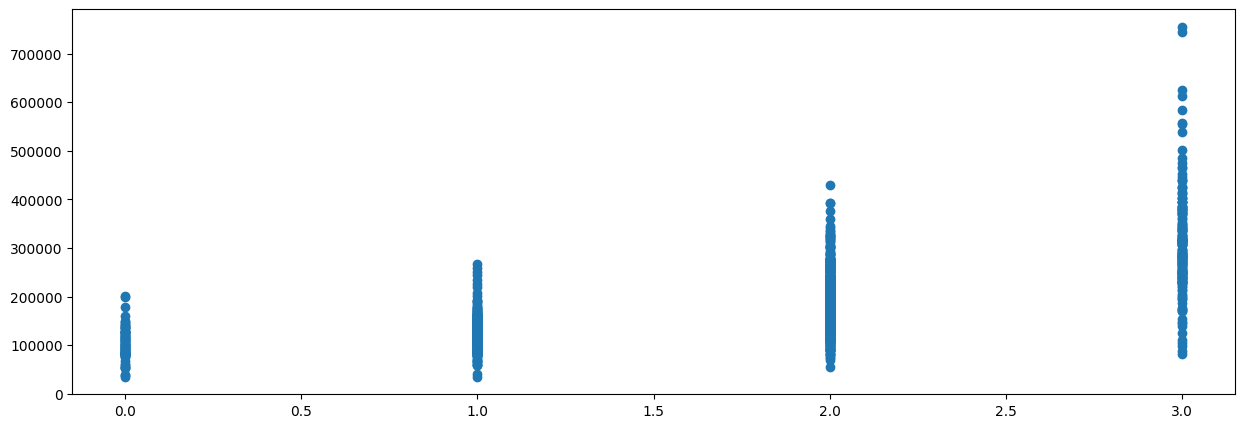

In [134]:
plt.scatter(data["GarageCars"], data["SalePrice"])

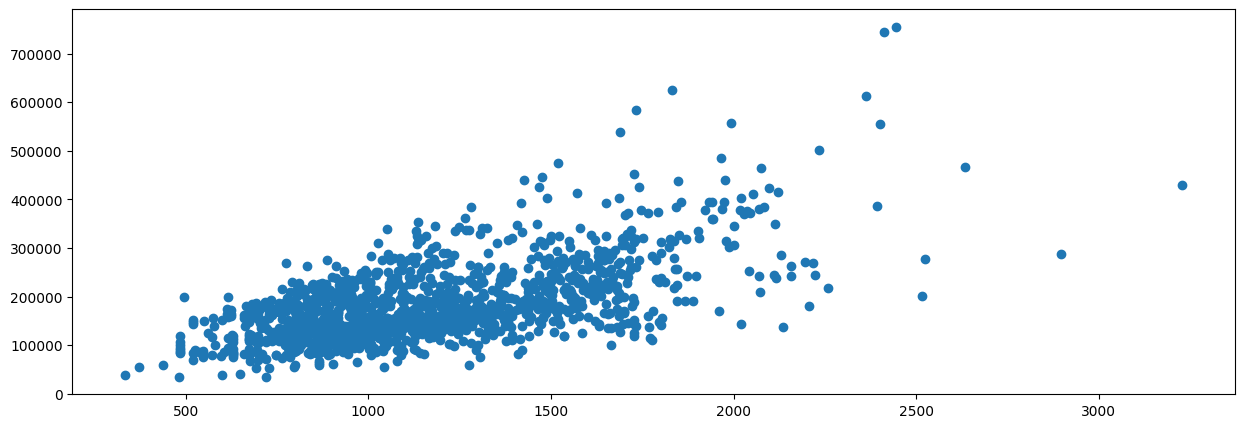

In [135]:
plt.scatter(data["1stFlrSF"], data["SalePrice"])

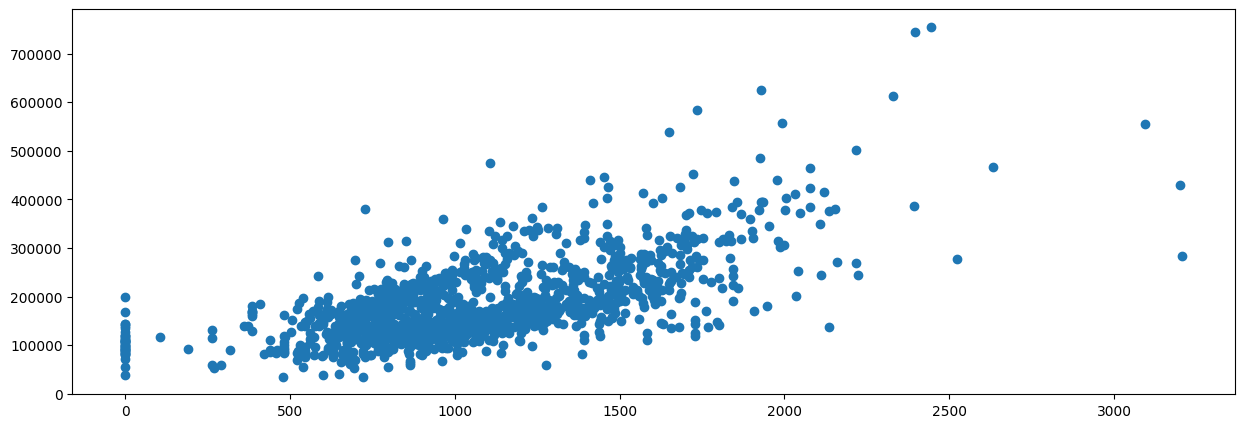

In [136]:
plt.scatter(data["TotalBsmtSF"], data["SalePrice"])

In [137]:
y = data['SalePrice']
x = data.drop('SalePrice', axis=1)

наличие пропусков в данных:

In [138]:
x.isna().sum()

LandContour      0
GarageYrBlt     81
FullBath         0
1stFlrSF         0
BsmtFinSF1       0
TotRmsAbvGrd     0
ExterQual        0
OpenPorchSF      0
Heating          0
Condition2       0
OverallQual      0
GarageCars       0
KitchenQual      0
KitchenAbvGr     0
GrLivArea        0
2ndFlrSF         0
CentralAir       0
BsmtQual        37
TotalBsmtSF      0
Fireplaces       0
dtype: int64

заполним пропуски у категориальных признаков пустыми значениями, а у числовых - 0.
P.S. Сначала необхожимо сконкатенировать тест и трейн, т.к. было выяснено, что некоторые значения отсутствуют в тестовом датасете, поэтому после OHE кол-во колонок отличется

In [148]:
len_x = x.shape[0]

In [149]:
len_x

1453

In [150]:
x.tail()

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,OverallQual,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces
1455,Lvl,1999.0,2,953,0,7,TA,40,GasA,Norm,6,2,TA,1,1647,694,Y,Gd,953,1
1456,Lvl,1978.0,2,2073,790,7,TA,0,GasA,Norm,6,2,TA,1,2073,0,Y,Gd,1542,2
1457,Lvl,1941.0,2,1188,275,9,Ex,60,GasA,Norm,7,1,Gd,1,2340,1152,Y,TA,1152,2
1458,Lvl,1950.0,1,1078,49,5,TA,0,GasA,Norm,5,1,Gd,1,1078,0,Y,TA,1078,0
1459,Lvl,1965.0,1,1256,830,6,Gd,68,GasA,Norm,5,1,TA,1,1256,0,Y,TA,1256,0


In [151]:
test_data.shape

(1459, 20)

In [152]:
data = pd.concat([x, test_data])
cat_features_mask = (data.dtypes == "object").values
data_cat = data[data.columns[cat_features_mask]].fillna("")
data_real = data[data.columns[~cat_features_mask]].fillna(0)

In [153]:
data.shape

(2912, 20)

In [154]:
print(data_cat.isna().sum(), data_real.isna().sum())

LandContour    0
ExterQual      0
Heating        0
Condition2     0
KitchenQual    0
CentralAir     0
BsmtQual       0
dtype: int64 GarageYrBlt     0
FullBath        0
1stFlrSF        0
BsmtFinSF1      0
TotRmsAbvGrd    0
OpenPorchSF     0
OverallQual     0
GarageCars      0
KitchenAbvGr    0
GrLivArea       0
2ndFlrSF        0
TotalBsmtSF     0
Fireplaces      0
dtype: int64


In [155]:
data = pd.concat([data_real, data_cat], axis=1)

# OHE

In [196]:
X_dum = pd.get_dummies(data, drop_first=True)
print(f"Data shape: {X_dum.shape}")
X_dum.head()

Data shape: (2912, 40)


,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,OpenPorchSF,OverallQual,GarageCars,KitchenAbvGr,GrLivArea,...,Condition2_RRNn,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,CentralAir_Y,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
0,2003.0,2,856,706.0,8,61,7,2.0,1,1710,...,False,False,False,True,False,True,False,False,True,False
1,1976.0,2,1262,978.0,6,0,6,2.0,1,1262,...,False,False,False,False,True,True,False,False,True,False
2,2001.0,2,920,486.0,6,42,7,2.0,1,1786,...,False,False,False,True,False,True,False,False,True,False
3,1998.0,1,961,216.0,7,35,7,3.0,1,1717,...,False,False,False,True,False,True,False,False,False,True
4,2000.0,2,1145,655.0,9,84,8,3.0,1,2198,...,False,False,False,True,False,True,False,False,True,False


In [197]:
X_dum.columns

Index(['GarageYrBlt', 'FullBath', '1stFlrSF', 'BsmtFinSF1', 'TotRmsAbvGrd',
       'OpenPorchSF', 'OverallQual', 'GarageCars', 'KitchenAbvGr', 'GrLivArea',
       '2ndFlrSF', 'TotalBsmtSF', 'Fireplaces', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'ExterQual_Fa', 'ExterQual_Gd',
       'ExterQual_TA', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav',
       'Heating_OthW', 'Heating_Wall', 'Condition2_Feedr', 'Condition2_Norm',
       'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe',
       'Condition2_RRAn', 'Condition2_RRNn', 'KitchenQual_Ex',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'CentralAir_Y',
       'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA'],
      dtype='object')

In [198]:
train_data = X_dum[:len_x]
test_data = X_dum[len_x:]

In [199]:
test_data.shape

(1459, 40)

# NORMILIZE

In [231]:
normalizer = MinMaxScaler()
x_train = normalizer.fit_transform(train_data)
x_test = normalizer.transform(test_data)
x_train = pd.DataFrame(data=x_train)
x_test = pd.DataFrame(data=x_test)
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.996517,0.666667,0.180373,0.322669,0.500000,0.111517,0.666667,0.666667,0.333333,0.332207,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.983085,0.666667,0.320663,0.446984,0.333333,0.000000,0.555556,0.666667,0.333333,0.224046,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.995522,0.666667,0.202488,0.222121,0.333333,0.076782,0.666667,0.666667,0.333333,0.350555,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.994030,0.333333,0.216655,0.098720,0.416667,0.063985,0.666667,1.000000,0.333333,0.333897,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.995025,0.666667,0.280235,0.299360,0.583333,0.153565,0.777778,1.000000,0.333333,0.450024,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# Model

ПОСКОЛЬКУ ДАННЫХ НЕМНОГО, БУДЕМ ИСПОЛЬЗОВАТЬ НЕ РАЗБИЕНИЕ НА TRAIN, VAL, А КРОСС-ВАЛИДАЦИЮ

In [219]:
K = 5
kf = KFold(n_splits=K, random_state=None, shuffle=True)

def fold(model, name_model):
    kf = KFold(K, shuffle=True, random_state=42).get_n_splits(x_train.values)

    rmse= np.sqrt(-cross_val_score(model, x_train.values, y, scoring="neg_mean_squared_error", cv = kf))
    print(f"{name_model} Train: {np.mean(rmse)}")
    return(rmse)


In [221]:
lr = LinearRegression()
lr_loss = fold(lr, 'LinearRegression')

LinearRegression Train: 28570.17136285528


In [223]:
lasso = Lasso(15)
lasso_loss = fold(lasso, 'LASSO')

LASSO Train: 28395.71225270819


In [224]:
# Создание и обучение модели случайного леса
model_rf = RandomForestRegressor()
lasso_loss = fold(model_rf, 'RandomForestRegressor')

RandomForestRegressor Train: 26940.89671766171


In [225]:
# Создание и обучение модели градиентного бустинга
model_gbr = GradientBoostingRegressor()
gbr_loss = fold(model_gbr, 'GradientBoostingRegressor')

GradientBoostingRegressor Train: 25135.72662450064


In [226]:
model_xgb = xgb.XGBRegressor()
xgb_loss = fold(model_xgb, 'XGBRegressor')

XGBRegressor Train: 26925.2768841911


In [245]:
model_gbr.fit(x_train, y)
res = model_gbr.predict(x_test).round()
pd.DataFrame({'Id': x_test.reset_index().index, 'SalePrice' : res}).to_csv('submission.csv', index=False)